Projets évaluation Mod Maths : entraînement classifieur VIT, dataset EMNIST

In [1]:
import torch
import torchvision

C:\Users\Clement\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] La procédure spécifiée est introuvable'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = torch.device("cuda")
print(device)

cuda


In [3]:
transform = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize(std=0.5, mean=0.5)
])
print(transform)

Compose(
    ToTensor()
    Normalize(mean=0.5, std=0.5)
)


In [4]:
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST

emnist_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Téléchargement dataset

In [5]:
emnist_train_dataset = EMNIST(root='./data', split='letters', train=True, transform=emnist_transform, download=True)
emnist_test_dataset = EMNIST(root='./data', split='letters', train=False, transform=emnist_transform, download=True)

In [6]:
batch_size = 32

emnist_train_loader = torch.utils.data.DataLoader(dataset=emnist_train_dataset, batch_size=batch_size, shuffle=True)
emnist_test_loader = torch.utils.data.DataLoader(dataset=emnist_test_dataset, batch_size=batch_size, shuffle=False)
print(emnist_train_loader)
print(emnist_test_loader)

In [7]:
examples = enumerate(emnist_test_loader)
batch_idx, data = next(examples)
print(len(data))

2


Génération images du dataset

Dimensions de la première image EMNIST: torch.Size([1, 28, 28])
Dimensions des images EMNIST:
Batch(s): 124800
Channel(s): 1
Height: 1
Width: 28
Labels: torch.Size([124800])
tensor([23,  7, 16,  ..., 13, 15, 19])


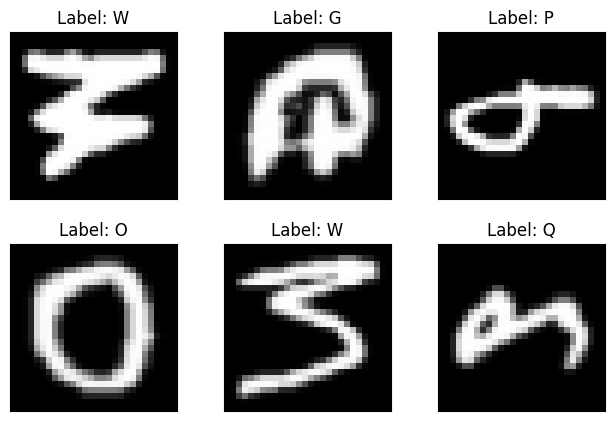

In [8]:
import string
import matplotlib.pyplot as plt

print('Dimensions de la première image EMNIST:', emnist_train_dataset[0][0].shape)
print('Dimensions des images EMNIST:')
b = len(emnist_train_dataset)
c = 1
h = emnist_train_dataset[0][0].shape[0]
w = emnist_train_dataset[0][0].shape[1]
print('Batch(s):', b)
print('Channel(s):', c)
print('Height:', h)
print('Width:', w)

print('Labels:', emnist_train_dataset.targets.shape)
print(emnist_train_dataset.targets)


alphabet = list(string.ascii_uppercase)

decalage_lettres = -1

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()

    if len(emnist_train_dataset[i][0].shape) == 3:
        plt.imshow(emnist_train_dataset[i][0][0], cmap='gray', interpolation='none')
    else:
        plt.imshow(emnist_train_dataset[i][0], cmap='gray', interpolation='none')

    label_index = emnist_train_dataset[i][1] + decalage_lettres
    letter = alphabet[label_index]

    plt.title(f'Label: {letter}')
    plt.xticks([])
    plt.yticks([])

plt.show()


In [9]:
from TP5_MHA import MultiHeadAttention

class VisionEncoder(torch.nn.Module):
    def __init__(self, embed_size, num_heads, dropout):
        super(VisionEncoder, self).__init__()

        self.embed_size = embed_size
        self.num_heads = num_heads
        self.dropout = dropout

        self.norm1 = torch.nn.LayerNorm(self.embed_size)
        self.attention = MultiHeadAttention(self.embed_size, self.num_heads, self.dropout)
        self.norm2 = torch.nn.LayerNorm(self.embed_size)
        self.mlp = torch.nn.Sequential(torch.nn.Linear(embed_size, embed_size*4), torch.nn.GELU(), torch.nn.Dropout(0.2), torch.nn.Linear(embed_size*4, embed_size), torch.nn.Dropout(0.2))

    def forward(self, x):
        x.expand(32,-1,-1)
        fwd_norm1 = self.norm1(x)
        fwd_attention = self.attention(fwd_norm1, fwd_norm1, fwd_norm1)
        fwd_norm2 = self.norm2(fwd_attention)
        fwd_mlp = fwd_attention + self.mlp(fwd_norm2)

        return fwd_mlp


In [10]:
class ViT(torch.nn.Module):
    def __init__(self, image_size, channel_size, patch_size, embed_size, nb_heads, classes, nb_layers, hidden_size, dropout):
        super(ViT, self).__init__()

        self.patch_size = patch_size
        self.embed_size = embed_size
        self.nb_patches = (image_size // patch_size) ** 2
        self.pixels_per_patch = channel_size * (patch_size ** 2)
        self.nb_heads = nb_heads
        self.classes = classes
        self.nb_layers = nb_layers
        self.hidden_size = hidden_size
        self.dropout = dropout

        self.embedding = torch.nn.Linear(self.pixels_per_patch,embed_size)
        self.dropout_layer = torch.nn.Dropout(dropout)

        self.encoders = torch.nn.ModuleList([])
        for i in range(self.nb_layers):
            self.encoders.append(VisionEncoder(self.embed_size, self.nb_heads, self.dropout))

        self.norm = torch.nn.LayerNorm(self.embed_size)
        self.classifier = torch.nn.Linear(self.embed_size, self.classes)


    def forward(self, img_torch):
        b, c, h, w = img_torch.size()
        img_torch_reshape = img_torch.reshape(b, int((h / self.patch_size) * (w / self.patch_size)), c * self.patch_size * self.patch_size)
        fwd_embeddings = self.embedding(img_torch_reshape)
        class_token = torch.randn(b,1,self.embed_size).to(device)
        fwd_cat_class_token = torch.cat((fwd_embeddings, class_token),1)

        positional_encoding = torch.randn(1,self.nb_patches + 1,self.embed_size).to(device)
        fwd_pos_encoding = fwd_cat_class_token + positional_encoding
        fwd_dropout = self.dropout_layer(fwd_pos_encoding)

        for encoder in self.encoders:
            fwd_dropout = encoder(fwd_dropout)

        fwd_cls = fwd_dropout[:, -1]
        fwd_cls = self.norm(fwd_cls)
        fwd_cls = self.classifier(fwd_cls)
        fwd_softmax = torch.nn.functional.log_softmax(fwd_cls, -1)
        return fwd_softmax

num_classes_emnist = 27
model = ViT(image_size=28, channel_size=1, patch_size=7, embed_size=512, nb_heads=8, classes=num_classes_emnist, nb_layers=3, hidden_size=256, dropout=0.2).to(device)
print(model)

ViT(
  (embedding): Linear(in_features=49, out_features=512, bias=True)
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (encoders): ModuleList(
    (0-2): 3 x VisionEncoder(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (dropout_layer): Dropout(p=0.2, inplace=False)
        (Q): Linear(in_features=512, out_features=512, bias=True)
        (K): Linear(in_features=512, out_features=512, bias=True)
        (V): Linear(in_features=512, out_features=512, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
      )
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (norm): Lay

In [11]:
loss_fct = torch.nn.NLLLoss()
print(loss_fct)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
print(optimizer)

NLLLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 5e-05
    maximize: False
    weight_decay: 0
)


Accuracy du classificateur

In [12]:

losses = []
accuracies = []
nb_epochs = 10

for epoch in range(nb_epochs):
    model.train()
    epoch_loss = 0
    y_pred = []
    y_true = []

    for batch_idx, (imgs, labels) in enumerate(emnist_train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        predictions = model(imgs)
        loss = loss_fct(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred.extend(predictions.argmax(dim=1).tolist())
        y_true.extend(labels.detach().tolist())
        epoch_loss += loss.item()


    losses.append(epoch_loss)
    nb_imgs = len(y_pred)
    total_correct = 0
    for i in range(nb_imgs):
        if y_pred[i] == y_true[i]:
            total_correct += 1
    accuracy = total_correct * 100 / nb_imgs
    accuracies.append(accuracy)

    print("----------")
    print("Epoch:", epoch)
    print("Loss:", epoch_loss)
    print(f"Accuracy: {accuracy} % ({total_correct} / {nb_imgs})")

----------
Epoch: 0
Loss: 10255.391868114471
Accuracy: 21.052884615384617 % (26274 / 124800)
----------
Epoch: 1
Loss: 7568.034513473511
Accuracy: 39.743589743589745 % (49600 / 124800)
----------
Epoch: 2
Loss: 6212.901568174362
Accuracy: 50.20592948717949 % (62657 / 124800)
----------
Epoch: 3
Loss: 5302.59816879034
Accuracy: 57.37179487179487 % (71600 / 124800)
----------
Epoch: 4
Loss: 4595.389219462872
Accuracy: 62.97996794871795 % (78599 / 124800)
----------
Epoch: 5
Loss: 4068.514709085226
Accuracy: 67.13701923076923 % (83787 / 124800)
----------
Epoch: 6
Loss: 3666.611813634634
Accuracy: 70.10897435897436 % (87496 / 124800)
----------
Epoch: 7
Loss: 3332.949974447489
Accuracy: 72.76442307692308 % (90810 / 124800)
----------
Epoch: 8
Loss: 3057.9029946029186
Accuracy: 74.94871794871794 % (93536 / 124800)
----------
Epoch: 9
Loss: 2829.3840094208717
Accuracy: 76.65544871794872 % (95666 / 124800)


Graphiques des performances

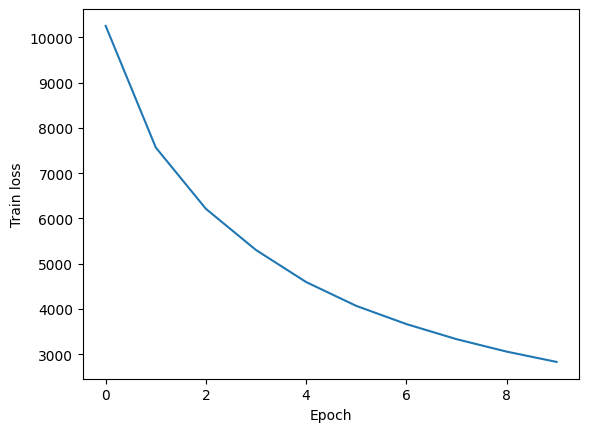

In [13]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Train loss")
plt.show()

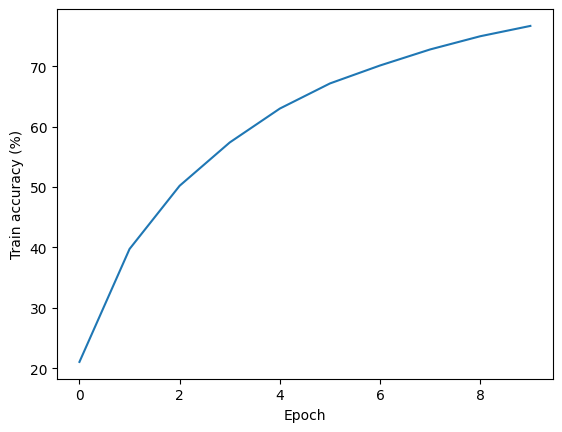

In [14]:
plt.plot(accuracies)
plt.xlabel("Epoch")
plt.ylabel("Train accuracy (%)")
plt.show()

In [15]:
with torch.no_grad():
    model.eval()
    y_test_pred = []
    y_test_true = []

    for batch_idx, (imgs, labels) in enumerate(emnist_test_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        if labels.size() == torch.Size([32]):
          predictions = model(imgs)
          y_test_pred.extend(predictions.argmax(dim=1).tolist())
          y_test_true.extend(labels.detach().tolist())

    nb_imgs = len(y_test_pred)
    total_correct = 0
    for i in range(nb_imgs):
        if y_test_pred[i] == y_test_true[i]:
            total_correct += 1
    accuracy = total_correct * 100 / nb_imgs

    print(f"Evaluation accuracy: {accuracy} % ({total_correct} / {nb_imgs})")


Evaluation accuracy: 74.72596153846153 % (15543 / 20800)


Télécharger les données du model

In [16]:
torch.save(model.state_dict(), 'model.pth')

Récupération des données du model

In [17]:
checkpoint = torch.load('model.pth', map_location=torch.device('cpu'))
model.load_state_dict({k: v for k, v in checkpoint.items() if k in model.state_dict()})

model.eval()

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

emnist_dataset = torchvision.datasets.EMNIST('./data/', split='letters', download=True, transform=transform)
print(emnist_dataset)


Dataset EMNIST
    Number of datapoints: 124800
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
